# Tutorial to Work with a NUCAPS (NOAA-20) Sounding data file

This code was written in December 2022 by Dr. Rebekah Esmaili, STC at NOAA/JPSS (rebekah.esmaili@noaa.gov) and Dr. Amy Huff, IMSG at NOAA/NESDIS/STAR (amy.huff@noaa.gov).

This tutorial will demonstrate how to work with a NUCAPS Level 2 netCDF4 file, including how to work with multiple pressure levels.

The main steps are:
- Open the file
- Read the global file metadata & the metadata for variables in the file
- Extract a profile and make a Skew-T plot
- Save image file

## Step 1-2: Launch Jupyter Notebooks

### Import Python packages

We will use three Python packages (libraries) and two Python modules in this tutorial:
- The **xarray** library is used to work with labelled multi-dimensional arrays
- The **NumPy** library is used to perform array operations
- The **Matplotlib** library is used to make plots
- The **datetime** module is used to manipulate dates and times
- The **pathlib** module is used to set filesystem paths for the user's operating system

In [65]:
from glob import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cartopy.crs as ccrs

In [4]:
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Set directory path and file name for satellite data file

We set the directory path for the satellite data file using the **pathlib** module, which automatically uses the correct format for the user's operating system. This helps avoid errors in situations when more than one person is using the same code file, because Windows uses back slashes in directory paths, while MacOS and Linux use forward slashes. 

More information about the **pathlib** module: https://docs.python.org/3/library/pathlib.html#module-pathlib

To keep things simple for this training, we put the satellite data files we downloaded in the current working directory ("cwd"), i.e., the same Jupyter Notebook folder where this code file is located.

We set the "directory_path" as the current working directory and the "file_name" of the netCDF4 satellite data file, and then set the full path for the data file ("file_id") using **pathlib** syntax.

In [11]:
directory_path = Path.cwd()
file_name = 'NUCAPS-EDR_v3r0_j01_s202211291907510_e202211291908210_c202211291938370.nc'
file_id = directory_path / file_name

## Step 3: Understand the structure and contents of the file(s)

### Open satellite data file using xarray & read metadata

We open the satellite data file using "xr.open_dataset" and then print the file metadata. The contents of a satellite data file are called a "Dataset" in **xarray**, conventionally abbreviated as "ds". 

The global file metadata are listed under "Attributes".

For any of the "Data variables" or "Coordinates", click on the attributes icon (little page) to see array metadata and the data repository icon (little server) to see an array summary.

The satellite data in the file are displayed under "Data variables".  A data variable is called a "DataArray" in **xarray**, conventionally abbreviated as "da".

In [17]:
ds = xr.open_dataset(file_name, engine='netcdf4')
ds

# nucaps = xr.open_dataset(file_name, engine='netcdf4', decode_times=False)
# nucaps['Time']=nucaps['Time']/1000.0
# nucaps.Time.attrs = {'units': 'seconds since 1970-01-01'}
# nucaps = xr.decode_cf(nucaps)

<xarray.Dataset>
Dimensions:               (Number_of_CrIS_FORs: 120, Number_of_Ispares: 129,
                           Number_of_Rspares: 298, Number_of_Cloud_Layers: 8,
                           Number_of_P_Levels: 100,
                           Number_of_MW_Spectral_Pts: 16,
                           Number_of_Surf_Emis_Hinge_Pts: 100,
                           Number_of_Stability_Parameters: 16,
                           Number_of_Cloud_Emis_Hing_Pts: 100)
Coordinates:
    Time                  (Number_of_CrIS_FORs) datetime64[ns] ...
    Latitude              (Number_of_CrIS_FORs) float32 ...
    Longitude             (Number_of_CrIS_FORs) float32 ...
    Pressure              (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
    Effective_Pressure    (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_CrIS_FORs, Number_of_Ispares,
                                Number_of_Rspares, Number_of_Cloud_Layers,
                                Number_of_P_Levels, Number_of_MW_Spectral_Pts,
                                Number_of_Surf_Emis_Hinge_Pts,
                                Number_of_Stability_Parameters,
                                Number_of_Cloud_Emis_Hing_Pts
Data variables: (12/64)
    quality_information   |S1 ...
    CrIS_FORs             (Number_of_CrIS_FORs) float64 ...
    View_Angle            (Number_of_CrIS_FORs) float32 ...
    Satellite_Height      (Number_of_CrIS_FORs) float32 ...
    FG_Mean_CO2           (Number_of_CrIS_FORs) float32 ...
    Mean_CO2              (Number_of_CrIS_FORs) float32 ...
    ...                    ...
    FG_IR_Surface_Emis    (Number_of_CrIS_FORs, Number_of_Surf_Emis_Hinge_Pts) float32 ...
    IR_Surface_Refl       (Number_of_CrIS_FORs, Number_of_Surf_Emis_Hinge_Pts) float32 ...
    Stability             (Number_of_CrIS_FORs, Number_of_Stability_Parameters) float32 ...
    Cloud_Freq            (Number_of_CrIS_FORs, Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
    Cloud_Emis            (Number_of_CrIS_FORs, Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
    Cloud_Refl            (Number_of_CrIS_FORs, Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
Attributes: (12/51)
    Conventions:                              CF-1.5
    Metadata_Conventions:                     CF-1.5, Unidata Datasset Discov...
    standard_name_vocabulary:                 CF Standard Name Table (version...
    project:                                  NPP Data Exploitation
    title:                                    NUCAPS_EDR
    summary:                                  NUCAPS retrieved profiles of te...
    ...                                       ...
    production_environment:                   OE
    number_valid_scans:                       4
    geospatial_bounds:                        POLYGON((-101.80 27.75, -93.65 ...
    instrument_resolution:                    CrIS 2211 channels
    number_valid_fovs:                        9
    retrieval_mode:                           IR+MW

## Step 4: Handling data arrays

There are 120 Number_of_CrIS_FORs (thus, profiles) inside the NUCAPS file. Each profile has 100 pressure levels (inferred from Number_of_P_Levels). We won't cover the other dimensions in the file.

There are a lot of variables in this file (63). Let's also examine the quality flag (Quality_Flag), Latitude, and Longitude. Later, we'll examine air temperature (Temperature) and water vapor mixing ratio (H2O_MR).

In [38]:
lat = ds.Latitude
lon = ds.Longitude
qf = ds.Quality_Flag

### Make a quick look map of the NUCAPS plan view

Since we're working with higher dimensional data, let's start with a simple map to see where the NUCAPS data are located. The data are all one dimensional, so we can make a scatter plot to show the center point of each profile, which are color coded by the quality (Quality_Flag = 0 are retrievals that passed QC).

In [58]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

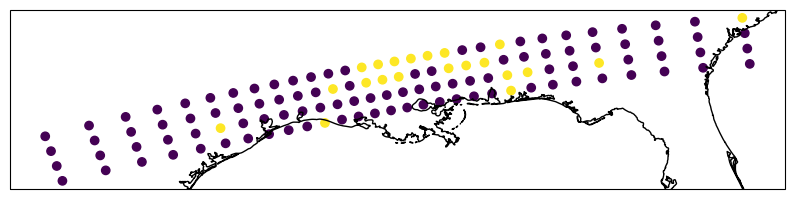

In [67]:
plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(lon, lat, c=qf, vmin=0, vmax=1)

plt.show()

## Small diversion: creating custom color bar colors

Since the data above are not continuous (there are two values, Pass and Fail quality control), we might have to create a custom colorbar for the data. We can either define the colors manually using their hexadecimal values or extract values from the 

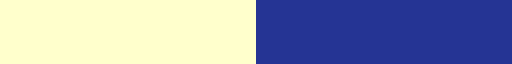

In [64]:
# Create a new colormap
colors = ["#ffffcc", "#253494"]
my_cmap1 = mpl.colors.ListedColormap(colors, name="NUCAPS_QC")
my_cmap1

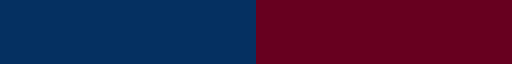

In [66]:
# Extract from existing colormap
my_cmap2 = mpl.colormaps['RdBu_r'].resampled(2)
my_cmap2

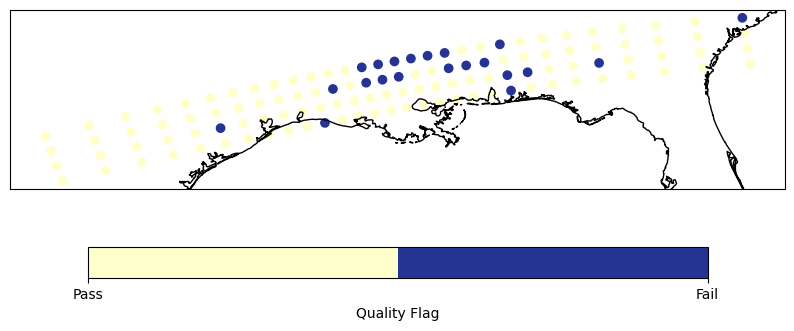

In [56]:
plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()

cbar = plt.scatter(lon, lat, c=qf, vmin=0, vmax=1, cmap=my_cmap1)

plt.colorbar(cbar, shrink=0.8, orientation='horizontal', ticks=range(2), label='Quality Flag').ax.set_xticklabels(['Pass', 'Fail'])

plt.show()

In [18]:
air_temp = ds['Temperature']
qc = ds['Quality_Flag']
lon = ds['Longitude']
lat = ds['Latitude']

type(air_temp)

xarray.core.dataarray.DataArray

In [19]:
# To extract just the data (and not the metadata)
air_temp_vals = ds['Temperature'].values

type(air_temp_vals)

numpy.ndarray

In [ ]:
air_temp.isel(Number_of_CrIS_FORs=0, Number_of_P_Level=slice()

In [13]:
footprint = nucaps.sel(Number_of_CrIS_FORs=82)

print(footprint.Time.values)

T = np.flip(footprint.Temperature.values.flatten())*units('K')
T=T.to(units.celsius)
MR = np.flip(footprint.H2O_MR.values.flatten())*units('kg/kg')
P = np.flip(footprint.Pressure.values.flatten())*units('millibar')
H = mpcalc.pressure_to_height_std(P).to(units.m)

2022-11-17T00:44:52.382999296


In [14]:
RH = mpcalc.relative_humidity_from_mixing_ratio(P, T, MR)
Td = mpcalc.dewpoint_from_relative_humidity(T, RH)

/home/rebekah/miniconda3/envs/notebook_demo/lib/python3.11/site-packages/metpy/calc/thermo.py:1114: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


In [15]:
Psurf = footprint.Surface_Pressure.item()*units('millibar')
mask = (P < Psurf) & (P >= 100*units('millibar'))

In [16]:
timestr = footprint.Time.dt.strftime('%d %b %Y %H:%M UTC').item()
locstr = "("+str(footprint.Latitude.values.round(1))+"$^\circ$N, "+str(np.abs(footprint.Longitude.values.round(1)))+"$^\circ$W)"

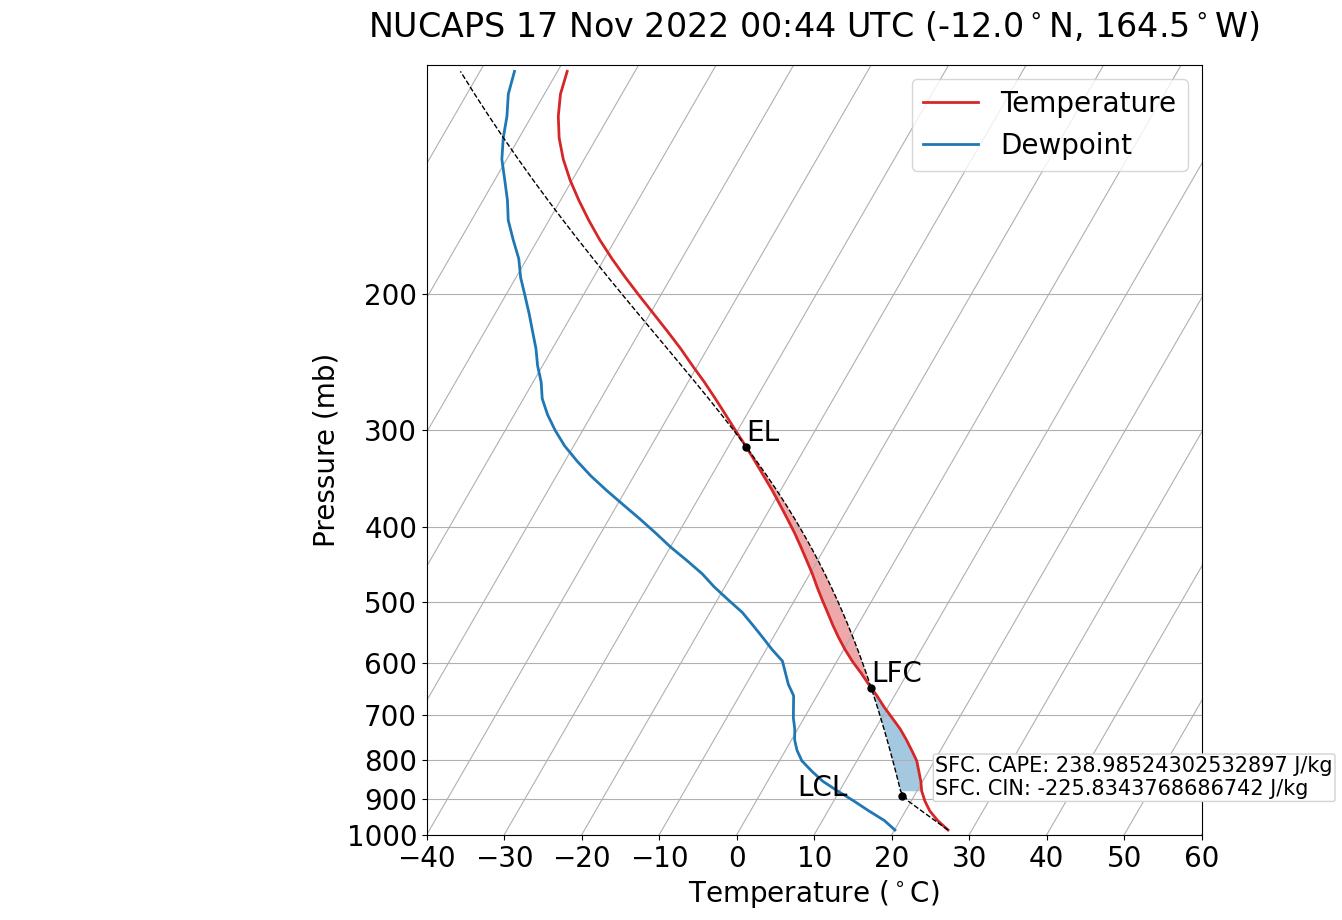

In [19]:
plt.rcParams.update({'font.size': 20})

P1 = P[mask]
T1 = T[mask]
Td1 = Td[mask]

# Shade CAPE/CIN
prof = mpcalc.parcel_profile(P1, T1[0], Td1[0]).to('degC')

# Calc lcl, cape vals
lcl_pressure, lcl_temperature = mpcalc.lcl(P1[0], T1[0], Td1[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(P1, T1, Td1)
el_pressure, el_temperature = mpcalc.el(P1, T1, Td1)

sfc_cape, sfc_cin = mpcalc.surface_based_cape_cin(P1, T1, Td1)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(P1, T1, Td1)

# label = 'SFC. CAPE: '+str(sfc_cape.magnitude.round())+' J/kg\n'+'SFC. CIN: '+str(sfc_cin.magnitude.round())+' J/kg'
# label = label+'\nML. CAPE: '+str(mlcape.magnitude.round())+' J/kg\n'+'ML. CIN: '+str(mlcin.magnitude.round())+' J/kg'

# Make plot -------
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, aspect='auto')

skew.plot(P1, T1, label='Temperature', color='tab:red', lw=2)
skew.plot(P1, Td1, label='Dewpoint',  color='tab:blue', lw=2)

skew.ax.legend(loc='upper right')

skew.ax.set_ylim(1000, 101)
skew.ax.set_xlim(-40, 60)

# Plot LCL
skew.plot(el_pressure, el_temperature, marker='.', c='k', markersize=10)
skew.plot(lfc_pressure, lfc_temperature, marker='.', c='k', markersize=10)
skew.plot(lcl_pressure, lcl_temperature, marker='.', c='k', markersize=10)

# ax = plt.gca()
skew.ax.annotate('EL', xy=(el_temperature, el_pressure), va="bottom", ha="left")
skew.ax.annotate('LFC', xy=(lfc_temperature, lfc_pressure), va="bottom", ha="left")
skew.ax.annotate('LCL', xy=(5, lcl_pressure))

skew.ax.annotate(label, xy=(23, 900), va="bottom", ha="left", size=15, bbox=dict(boxstyle="round, pad=0.1", fc="white", ec="lightgrey", lw=1))

# Plot Profile
skew.plot(P1, prof, c='k', linewidth=1, markersize=1, linestyle='dashed')

# Shade areas of CAPE and CIN
skew.shade_cin(P1, T1, prof, Td1)
skew.shade_cape(P1, T1, prof)

# ax = plt.gca()
skew.ax.set_xlabel('Temperature ($^\circ$C)')
skew.ax.set_ylabel('Pressure (mb)')
skew.ax.set_title("NUCAPS "+timestr+" "+locstr, pad=20)

plt.show()